# KPIs

In [9]:
import pandas as pd
from datetime import date, timedelta
from datetime_truncate import truncate
import matplotlib.pyplot as plt
from utils import style
import numpy as np
path = '/Users/jennamiles/Documents/credentials'

In [5]:
#this is from database.py
#need to update in utils because of directory issue
import os
from psycopg2 import connect
from pandas import read_sql

def query(sql_statement: str, **kwargs):
    with open(f'{path}', 'r') as credentials:
        connection = connect(credentials.read())
        cursor = connection.cursor()

        if len(kwargs) > 0:
            dataframe = read_sql(sql_statement.format(**kwargs), connection)
        else:
            dataframe = read_sql(sql_statement, connection)

        assert len(dataframe) > 0, 'query returned no results'
        return dataframe
    
def query_from_file(sql_file: str, **kwargs):
    with open(sql_file, 'r') as f:
        return query(f.read(), **kwargs)

In [273]:
df = query_from_file('pure.sql')

# Transactions, spend, customers by month and week

In [274]:
df['transaction_month'] = df['transaction_date'].apply(lambda x: truncate(x, 'month').date())
df['transaction_week'] = df['transaction_date'].apply(lambda x: truncate(x, 'week').date())



In [356]:
#select max full month & max full week 
today = date.today()
today_month = truncate(pd.to_datetime(today),'month').date()
today_week = truncate(pd.to_datetime(today),'week').date()
print(today)
print(today_month)
print(today_week)


2021-04-29
2021-04-01
2021-04-26


In [307]:
previous_date = today - timedelta(730)
day_range = pd.Series(pd.date_range(previous_date, today))
week_list = list(day_range.apply(lambda x: truncate(pd.to_datetime(x),'week').date()).drop_duplicates())
week_calendar = pd.DataFrame({'transaction_week':week_list})

- Spend/ revenue

In [328]:
monthly_spend = df.groupby('transaction_month').sum()['total_amount']/100
monthly_spend = monthly_spend[monthly_spend.index!=today_month]
monthly_spend_pc_change = ((monthly_spend - monthly_spend.shift(1))/monthly_spend.shift(1))*100

weekly_spend = df.groupby('transaction_week').sum()['total_amount']/100
weekly_spend = pd.merge(week_calendar, weekly_spend, on = 'transaction_week',how = 'left').fillna(0).set_index('transaction_week')
weekly_spend = weekly_spend[weekly_spend.index!=today_week]
weekly_spend_pc_change = (((weekly_spend - weekly_spend.shift(1))/weekly_spend.shift(1))*100).fillna(0)
weekly_spend_pc_change.columns = ['vol']


- Transactions

In [329]:
monthly_transactions = df.groupby('transaction_month').nunique()['receipt_id']
monthly_transactions = monthly_transactions[monthly_transactions.index!=today_month]
monthly_txns_pc_change = ((monthly_transactions - monthly_transactions.shift(1))/monthly_transactions.shift(1))*100

weekly_transactions = df.groupby('transaction_week').nunique()['receipt_id']
weekly_transactions = pd.merge(week_calendar, weekly_transactions, on = 'transaction_week',how = 'left').fillna(0).set_index('transaction_week')
weekly_transactions = weekly_transactions[weekly_transactions.index!=today_week]
weekly_txns_pc_change = (((weekly_transactions - weekly_transactions.shift(1))/weekly_transactions.shift(1))*100).fillna(0)
weekly_txns_pc_change.columns = ['vol']


- Customers

In [330]:
monthly_customers = df.groupby('transaction_month').nunique()['customer_id']
monthly_customers = monthly_customers[monthly_customers.index!=today_month]
monthly_customers_pc_change = ((monthly_customers - monthly_customers.shift(1))/monthly_customers.shift(1))*100


weekly_customers = df.groupby('transaction_week').nunique()['customer_id']
weekly_customers = pd.merge(week_calendar, weekly_customers, on = 'transaction_week',how = 'left').fillna(0).set_index('transaction_week')
weekly_customers = weekly_customers[weekly_customers.index!=today_week]
weekly_customers_pc_change = (((weekly_customers - weekly_customers.shift(1))/weekly_customers.shift(1))*100).fillna(0)
weekly_customers_pc_change.columns = ['vol']


- Put latest results into KPI dataframes

In [351]:
kpis_df1 = pd.DataFrame({'kpi':['spend','transactions','customers']
                             ,'value':[monthly_spend[-1],monthly_transactions[-1],monthly_customers[-1]]
                             ,'% change':[monthly_spend_pc_change[-1],monthly_txns_pc_change[-1],monthly_customers_pc_change[-1]]
                            })
kpis_df2 = pd.DataFrame({'kpi':['spend','transactions','customers']
                             ,'value':[weekly_spend.values[-1][0],weekly_transactions.values[-1][0],weekly_customers.values[-1][0]]
                             ,'% change':[weekly_spend_pc_change.values[-1][0],weekly_txns_pc_change.values[-1][0],weekly_customers_pc_change.values[-1][0]]
                            })




In [352]:
kpis_df1



,kpi,value,% change
0,spend,3586.42,80.062859
1,transactions,237.00,29.508197
2,customers,190.00,31.944444


In [353]:
kpis_df2



,kpi,value,% change
0,spend,3154.36,-12.764663
1,transactions,279.00,-2.787456
2,customers,233.00,-3.319502


In [ ]:
#add a display of the weekly metrics here to put in notion

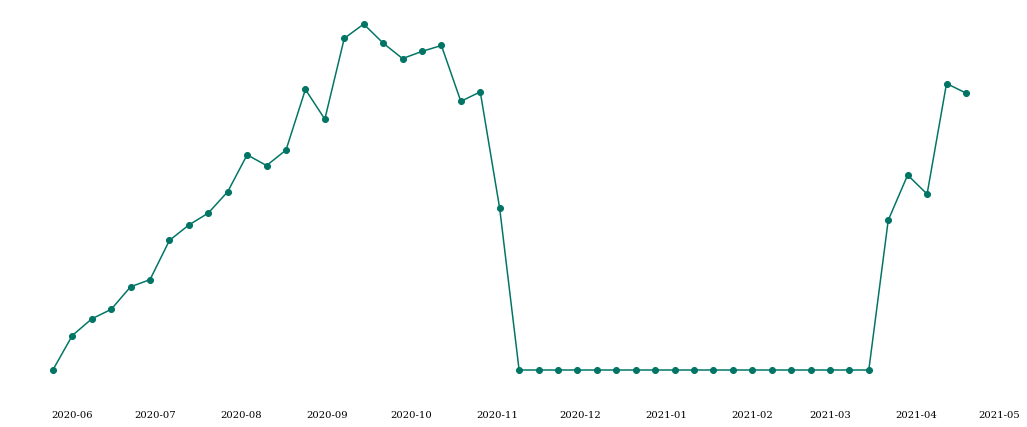

In [310]:
#plot the change over time in these metrics 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 7))
axes.plot(weekly_customers[-48:], marker = 'o')
axes.set_frame_on(False)
axes.tick_params(left=False, labelleft=False, bottom=False)



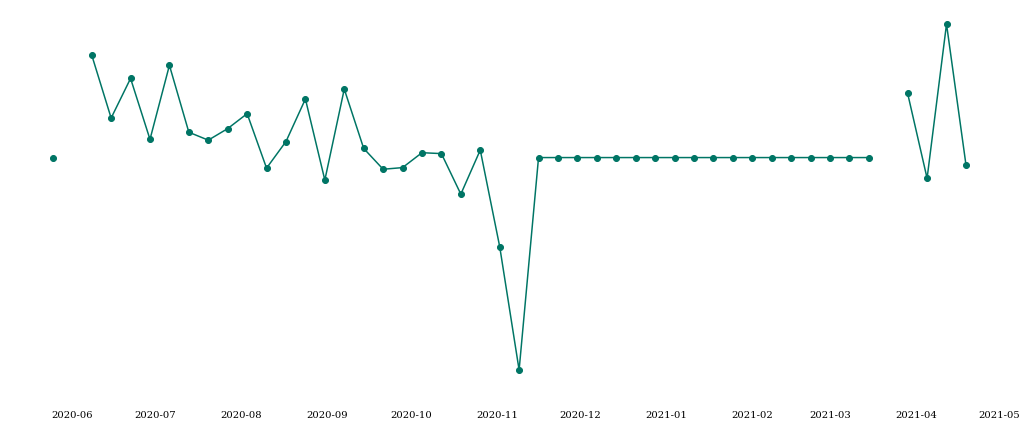

In [311]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 7))
axes.plot(weekly_customers_pc_change[-48:], marker = 'o')
axes.set_frame_on(False)
axes.tick_params(left=False, labelleft=False, bottom=False)


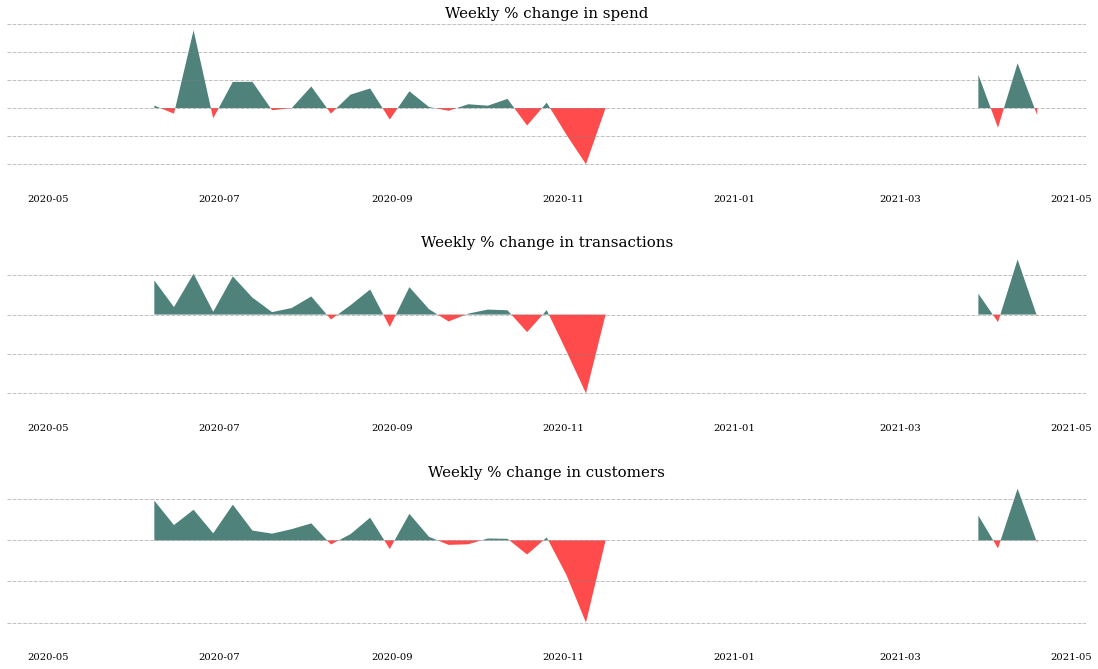

In [433]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 10))


kpi_objects = [weekly_spend_pc_change,weekly_txns_pc_change,weekly_customers_pc_change]
kpi_names = ['Weekly % change in spend','Weekly % change in transactions','Weekly % change in customers']
weeks = 52


for i in [0,1,2]:
    #set x and y 
    x = kpi_objects[i][-weeks:].index.values
    y = kpi_objects[i][-weeks:]['vol']
    # Plot
    ax = axes[i]
    ax.fill_between(x[1:], y[1:], 0, where=y[1:] >= 0, facecolor='tmnt', interpolate=True, alpha=0.7)
    ax.fill_between(x[1:], y[1:], 0, where=y[1:] <= 0, facecolor='red', interpolate=True, alpha=0.7)
    ax.set_frame_on(False)
    ax.yaxis.grid(color='grey', linestyle='-.', linewidth=0.5)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title(kpi_names[i], size = 15)

plt.tight_layout()
plt.show()

In [368]:
kpis_df2.loc[0]


kpi               spend
value       3154.360000
% change     -12.764663
Name: 0, dtype: object

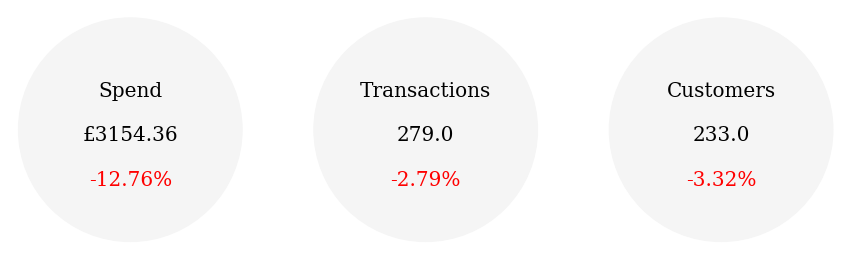

In [431]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize = (15,7))

for i in [0,1,2]:
    
    ax[i].set_frame_on(False)

    x = 0
    y = 0

    circle = plt.Circle((x, y), radius=1, color = 'snow')

    ax[i].add_patch(circle)
    kpi_text = kpis_df2.loc[i]['kpi'].title()
    if i == 0:
        middle_text = '£'+ kpis_df2.loc[i]['value'].astype('str')
    else:
        middle_text = (kpis_df2.loc[i]['value']).astype('str')
    pcent_text = round(kpis_df2.loc[i]['% change'],2).astype('str') + '%'

    label = ax[i].annotate(kpi_text, xy=(x, y+0.3), fontsize=20, ha="center", color = "black")
    label = ax[i].annotate(middle_text, xy=(x, y-0.1), fontsize=20, ha="center", color = "black")
    label = ax[i].annotate(pcent_text, xy=(x, y-0.5), fontsize=20, ha="center", color = "red")

    ax[i].axis('off')
    ax[i].set_frame_on(False)
    ax[i].tick_params(left=False, labelleft=False, bottom=False)
    ax[i].set_aspect('equal')
    ax[i].autoscale_view()

plt.show()

In [438]:
kpis_df2

,kpi,value,% change
0,spend,3154.36,-12.764663
1,transactions,279.00,-2.787456
2,customers,233.00,-3.319502


In [533]:
atv = kpis_df2['value'][0]/kpis_df2['value'][1]
atf = kpis_df2['value'][1]/kpis_df2['value'][2]
acv = kpis_df2['value'][0]/kpis_df2['value'][2]

atv_weekly = weekly_spend['total_amount']/weekly_transactions['receipt_id']
atv_weekly_pcent = (((atv_weekly-atv_weekly.shift(1))/atv_weekly.shift(1))*100).fillna(0)
atf_weekly = weekly_transactions['receipt_id']/weekly_customers['customer_id']
atf_weekly_pcent = (((atf_weekly-atf_weekly.shift(1))/atf_weekly.shift(1))*100).fillna(0)
acv_weekly = weekly_spend['total_amount']/weekly_customers['customer_id']
acv_weekly_pcent = (((acv_weekly-acv_weekly.shift(1))/acv_weekly.shift(1))*100).fillna(0)


averages = pd.DataFrame({'kpi':['ATV','ATF','ACV'],'value':[atv,atf,acv],'% change':[atv_weekly_pcent[-1],atf_weekly_pcent[-1],acv_weekly_pcent[-1]]})

In [536]:
averages

,kpi,value,% change
0,ATV,11.305950,-10.263291
1,ATF,1.197425,0.550313
2,ACV,13.538026,-9.769458


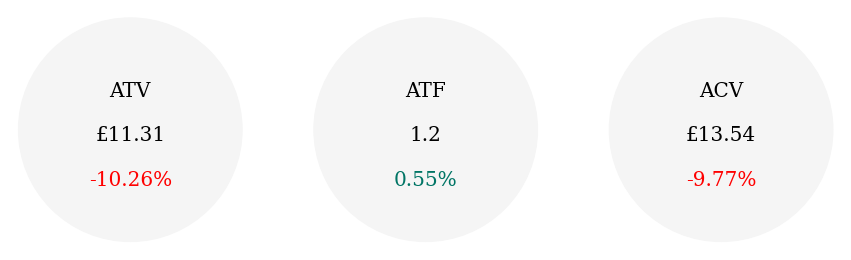

In [538]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize = (15,7))
averages_names = ['ATV','ATF','ACV']
for i in [0,1,2]:
    
    
    ax[i].set_frame_on(False)

    x = 0
    y = 0

    circle = plt.Circle((x, y), radius=1, color = 'snow')

    ax[i].add_patch(circle)
    kpi_text = averages_names[i]
    if i == 1:
        middle_text = round(averages.loc[i]['value'],2).astype('str')
    else:
        middle_text = '£'+ round(averages.loc[i]['value'],2).astype('str')
        
    pcent_text = round(averages.loc[i]['% change'],2).astype('str') + '%'

    label = ax[i].annotate(kpi_text, xy=(x, y+0.3), fontsize=20, ha="center", color = "black")
    label = ax[i].annotate(middle_text, xy=(x, y-0.1), fontsize=20, ha="center", color = "black")
    if averages.loc[i]['% change']<0:
        label = ax[i].annotate(pcent_text, xy=(x, y-0.5), fontsize=20, ha="center", color = "red")
    else:
        label = ax[i].annotate(pcent_text, xy=(x, y-0.5), fontsize=20, ha="center", color = "green")
        

    ax[i].axis('off')
    ax[i].set_frame_on(False)
    ax[i].tick_params(left=False, labelleft=False, bottom=False)
    ax[i].set_aspect('equal')
    ax[i].autoscale_view()

plt.show()

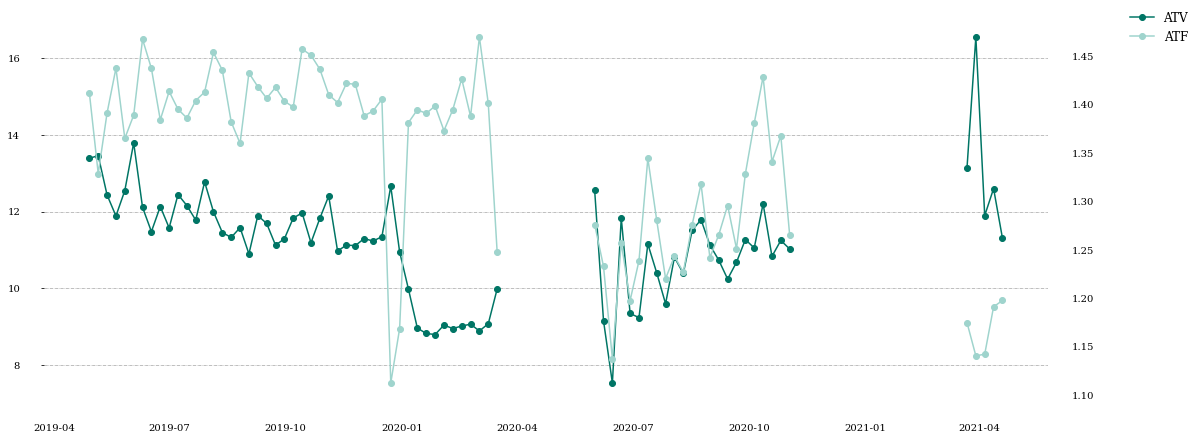

In [506]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 7))
axes.plot(atv_weekly, marker = 'o', label = 'ATV')
axes.set_frame_on(False)
axes.yaxis.grid(color='grey', linestyle='-.', linewidth=0.5)
axes.tick_params(left=True, labelleft=True, bottom=False)
axes.legend(fontsize= 12, loc = 'upper right',bbox_to_anchor=(1.15,1.05))
axes2=axes.twinx()
axes2.plot(atf_weekly, marker = 'o', color = 'mint', label = 'ATF')
axes2.set_frame_on(False)
axes2.legend(fontsize= 12, loc = 'upper right',bbox_to_anchor=(1.15,1))
axes2.tick_params(left=False, right = False, labelleft=False, bottom=False)
#_ = plt.title('Weekly ATV & ATF', size = 15)
#plt.tight_layout()


- ATF, ATV, ACV over time plot 
- Add to notion
- break
- 52-week Active customers
- 12-week Active
- 4-week Active
- Cumulative